# Supermarket Dataset For Predictive Marketing Using RFM
[Dataset on kaggle](https://www.kaggle.com/datasets/hunter0007/ecommerce-dataset-for-predictive-marketing-2023)

### Contents
* Data preprocessing 
* Modeling
* Evaluation

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
sns.set(font_scale=1.4)

In [2]:
data = pd.read_csv('ECommerce_consumer behaviour.csv')

In [3]:
data = data.dropna()

In [4]:
data.drop(['department', 'product_name'], axis=1, inplace=True)

In [5]:
data.head()

,order_id,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,department_id
22,1201011,147243,14,0,16,3.0,94,1,0,7
23,1201011,147243,14,0,16,3.0,83,2,0,4
24,1201011,147243,14,0,16,3.0,83,3,1,4
25,1201011,147243,14,0,16,3.0,24,4,1,4
26,1201011,147243,14,0,16,3.0,120,5,1,16


In [6]:
data.shape

(1895159, 10)

In [31]:
rfm = data.groupby('user_id').agg({
    'days_since_prior_order': lambda x: x.sort_values().iloc[-1],
    'order_id': 'count',
    'add_to_cart_order': 'sum'
})
rfm.head()

,days_since_prior_order,order_id,add_to_cart_order
user_id,,,
2,10.0,11,36
3,20.0,19,75
7,30.0,24,300
10,14.0,30,465
11,30.0,11,66


In [32]:
rfm.rename(columns={
    'days_since_prior_order': 'R',
    'order_id': 'F',
    'add_to_cart_order': 'M'
}, inplace=True)

In [33]:
rfm.head()

,R,F,M
user_id,,,
2,10.0,11,36
3,20.0,19,75
7,30.0,24,300
10,14.0,30,465
11,30.0,11,66


In [34]:
rfm.shape

(98918, 3)

# Rank Scaling

In [36]:
r_labels = range(4, 0, -1)
r_groups = pd.qcut(rfm['R'], q=4, labels=r_labels)

f_labels = range(1, 5)
f_groups = pd.qcut(rfm['F'], q=4, labels=f_labels)

m_labels = range(1, 5)
m_groups = pd.qcut(rfm['M'], q=4, labels=m_labels)

In [38]:
rfm['R_rank'] = r_groups.values
rfm['F_rank'] = f_groups.values
rfm['M_rank'] = m_groups.values
rfm.head()

,R,F,M,R_rank,F_rank,M_rank
user_id,,,,,,
2,10.0,11,36,3,2,2
3,20.0,19,75,2,3,3
7,30.0,24,300,1,3,4
10,14.0,30,465,2,4,4
11,30.0,11,66,1,2,2


In [75]:
sampled_data = rfm.sample(20000)
scaled_data = sampled_data[['R_rank', 'F_rank', 'M_rank']].values

# K-Means Clustering

In [78]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE

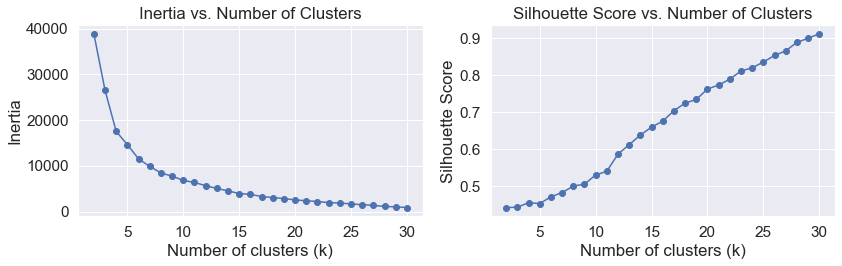

In [79]:
inertia = []
silhouette_scores = []
k_values = range(2, 31) 
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_data)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(scaled_data, kmeans.labels_))

# Plotting inertia and silhouette score
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(k_values, inertia, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Inertia vs. Number of Clusters')

plt.subplot(1, 2, 2)
plt.plot(k_values, silhouette_scores, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs. Number of Clusters')

plt.tight_layout()
plt.show()

In [80]:
kmeans = KMeans(n_clusters=30)
kmeans.fit(scaled_data)

KMeans(n_clusters=30)

In [89]:
sampled_data['Label'] = kmeans.labels_

In [90]:
sampled_data.head()

,R,F,M,R_rank,F_rank,M_rank,Label
user_id,,,,,,,
102268,14.0,51,676,2,4,4,4
14862,0.0,19,190,4,3,4,17
88227,1.0,5,15,4,1,1,5
18345,18.0,9,45,2,2,2,8
106666,25.0,9,45,2,2,2,8


In [92]:
sampled_data['Label'].value_counts()

5     1669
12    1397
0     1294
6     1221
11    1123
2     1114
3     1065
4     1046
10    1009
9      907
8      893
13     885
14     866
16     831
15     829
18     761
19     270
7      260
17     244
21     236
25     236
28     231
20     228
1      218
22     209
29     199
24     197
23     193
26     191
27     178
Name: Label, dtype: int64

In [85]:
silhouette_score(scaled_data, kmeans.labels_)

0.9082976061956655

In [86]:
kmeans.inertia_

933.9921333203665

---

In [93]:
sampled_data.describe().T

,count,mean,std,min,25%,50%,75%,max
R,20000.0,15.20840,9.671166,0.0,7.0,13.0,25.0,30.0
F,20000.0,19.15980,20.143693,1.0,7.0,13.0,24.0,236.0
M,20000.0,161.23555,278.368654,1.0,21.0,66.0,188.0,5406.0
Label,20000.0,10.26790,7.033470,0.0,5.0,10.0,15.0,29.0


In [94]:
sampled_data[sampled_data['Label'] == 5].describe().T

,count,mean,std,min,25%,50%,75%,max
R,1669.0,4.298382,2.239471,0.0,2.0,5.0,6.0,7.0
F,1669.0,3.855602,1.695353,1.0,2.0,4.0,5.0,7.0
M,1669.0,10.083883,6.672281,1.0,3.0,10.0,15.0,21.0
Label,1669.0,5.000000,0.000000,5.0,5.0,5.0,5.0,5.0


In [95]:
sampled_data[sampled_data['Label'] == 12].describe().T

,count,mean,std,min,25%,50%,75%,max
R,1397.0,29.604152,1.005748,26.0,30.0,30.0,30.0,30.0
F,1397.0,3.802434,1.889397,1.0,2.0,4.0,5.0,11.0
M,1397.0,9.476020,6.738805,1.0,3.0,9.0,15.0,21.0
Label,1397.0,12.000000,0.000000,12.0,12.0,12.0,12.0,12.0


In [96]:
sampled_data[sampled_data['Label'] == 0].describe().T

,count,mean,std,min,25%,50%,75%,max
R,1294.0,18.509274,3.460683,14.0,15.0,18.0,21.0,25.0
F,1294.0,4.323029,2.070859,1.0,3.0,4.0,6.0,12.0
M,1294.0,11.990726,8.606455,1.0,4.0,10.0,21.0,28.0
Label,1294.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0


In [97]:
sampled_data[sampled_data['Label'] == 6].describe().T

,count,mean,std,min,25%,50%,75%,max
R,1221.0,10.094185,1.778784,8.0,8.0,10.0,12.0,13.0
F,1221.0,53.004095,28.525240,25.0,33.0,44.0,63.0,236.0
M,1221.0,569.970516,497.064917,189.0,277.0,409.0,642.0,4738.0
Label,1221.0,6.000000,0.000000,6.0,6.0,6.0,6.0,6.0
